In [1]:
import argparse
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import itertools
import os
import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import roc_auc_score
import gc
from thefuzz import fuzz
from thefuzz import process
import time
import re
import recordlinkage
from sklearn.model_selection import train_test_split
from fastparquet import ParquetFile

gc.collect()

0

In [52]:
file1 = '~/Downloads/harvard-collectors.csv' ## hharvard-index-collectors.csv'
harvard_data = pd.read_csv(file1,chunksize=10000,encoding='utf-8',on_bad_lines='skip',engine='python')
harvard_data = pd.concat(harvard_data)
harvard_columns = harvard_data.columns.tolist()
harvard_data.rename(columns={harvard_columns[14]:'labelName'}, inplace=True) ## to avoid special character in colNames
harvard_columns = harvard_data.columns.tolist()   ## load content into list
harvard_data.head()
print("Finished loading Harvard Index data.")

file2 = '~/Downloads/wikidata-collectors-230615.csv'  ## macOS file location, wikipedia collector
wiki_data = pd.read_csv(file2,chunksize=10000,encoding='utf-8',on_bad_lines='skip',engine='python')
wiki_data = pd.concat(wiki_data)
wiki_columns = wiki_data.columns.tolist()   ## load content into list
wiki_data.head()
print("Finished loading Wiki data.")

file3 = '~/Downloads/collectors (1).parquet'
bionomia_data = pd.read_parquet(file3, engine='fastparquet')
bionomia_columns = bionomia_data.columns.tolist()   ## load content into list
bionomia_data.head()
print("Finished loading Bionomia data.")

Finished loading Harvard Index data.
Finished loading Wiki data.
Finished loading Bionomia data.


In [5]:
# Method to compute and plot the data distribution of a given dataframe
'''
Example:
distribution = get_distribution(wiki_data, wiki_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10), title = 'WikiData')
'''
def get_distribution(data, col):
    sum_count = 0
    data_distribution = {} ## a dictionary to store the distribution of individual entity
    data_distribution_sum = pd.DataFrame(columns = col, index=['sum'])
    for (columnName, columnData) in data.iteritems():
        temp = data[columnName].value_counts()
        data_distribution_sum.at['sum', columnName]=sum(temp)
    return data_distribution_sum

In [6]:
'''
# this function will remove all special charaters -- including spaces
# used process_time() for evaluation
Example:
newCol = remove_spec_in_col(wiki_data,'aliases')
'''
# Remove square blankets auto generated during data alignment process
def clean_text(text): # fb
    text = text.replace('[', '').replace(']','').replace("'", '')
    return text

def remove_spec_in_col(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            newCol.append(clean_text(rowValue))
        else:
            newCol.append(np.nan)
    return newCol

In [7]:
# Replace empty list as np.nan
def remove_empty(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if not rowValue:
            newCol.append(np.nan)
        else:
            newCol.append(rowValue)
    return newCol

In [8]:
'''
For Harvard Index data preprocessing
Example:
text1 = "[author note: Types at: MT] [collector note: col. with M. St-Arnaud; MT; BO]"
text2 = "[collector note: Herbarium (Piedmont (Italy): TO]"
text3 = "[collector note: SAFB] plant pathologist; short biography and photo: Can. J. Plant Pathol. Vol. 28: S21-S22. 2006."
text4 = "[collector note: BM-SL, OXF.]"
text5 = "[collector note: Herbarium and types, US, additional m,erial , B, C, DBN, GH, K, MIN, MO, NA, NY, PH"
text = "[author note: LE; temperate Asian Polygonaceae] [collector note: LE] "
temp = text4.split("[")

s1 = get_author_notes(temp)
s2 = get_collector_notes(temp)
print("\nFunction version:")
print("author note: ", s1)
for i in s1: print("\nHerbarium List: ", get_herbarium_codes(i))
print("collector note: ", s2)
for i in s2: print("\nHerbarium List: ", get_herbarium_codes(i))

a, b = get_author_collector_notes(harvard_data, 'Remarks')

b = harvard_data[['id', 'collector note']].copy()
b['collector note'] = extract_herbariums(b,'collector note')
'''
            
def get_author_notes(string):
    authorNotes = []
    for s in string:
        # s = clean_text(s)
        # authorNotes.append(s.partition("author note: ")[2].partition(" ")[0].replace(";", ''))
        authorNotes.append(s.partition("author note: ")[2].partition("]")[0].replace(";", ',').replace(":", ',').replace("(",",").replace(")",",").replace("at",","))
    authorNotes = list(filter(None, authorNotes))
    return authorNotes

def get_collector_notes(string):
    collectorNotes = []
    for s in string:
        # s = clean_text(s)
        # collectorNotes.append(s.partition("collector note: ")[2].partition(" ")[0].replace(";", ''))
        collectorNotes.append(s.partition("collector note: ")[2].partition("]")[0].replace(";", ',').replace(":", ',').replace("(",",").replace(")",",").replace("at",","))
    collectorNotes = list(filter(None, collectorNotes))
    return collectorNotes

def get_author_collector_notes(df, col):
    authorNoteCol = []
    collectorNoteCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            string = rowValue.split("[")
            authorNoteCol.append(get_author_notes(string))
            collectorNoteCol.append(get_collector_notes(string))
        else:
            authorNoteCol.append([]) # use empty to reduce runtime exception while condition checking
            collectorNoteCol.append([])
    return authorNoteCol, collectorNoteCol

# Functions to extract the herbarium institution codes from Remarks in Harvard Index
def get_herbarium_codes(string):
    herbarium_codes = []
    for s in string.split(","):
        if s.isupper():
            herbarium_codes.append(re.sub('[^A-Z]', ',', s).replace(",",""))
    return herbarium_codes

def extract_herbariums(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if rowValue:
            temp = []
            for i in rowValue: 
                temp += get_herbarium_codes(i)
            newCol.append(temp)
        else:
            newCol.append([])
    return newCol

In [9]:
'''
For Harvard Index data preprocessing
Example:
temp = harvard_data[['id','Name','Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty']].copy()
temp['combine_specialty'] = combine_specialty(temp)
# temp['combine_specialty'].value_counts().index.tolist()
'''
# Extract specialty areas of collectors
def combine_specialty(df):
    cols = ['Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty']
    newCol = df[cols].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in newCol.iteritems():
        if pd.notnull(rowValue):
            newCol[index] = set(clean_text(rowValue).replace('And',',').replace(' and ',',').replace(' ','').split(','))
        else:
            newCol[index] = np.nan
    return newCol

In [10]:
'''
For Harvard Index data preprocessing
Example:
temp = harvard_data[['id','Name','Geography Author', 'Geography Collector', 'Geography Determiner', 'Geography']].copy()
temp['combine_geography'] = combine_geography(temp)
# temp['combine_geography'].value_counts().index.tolist()
'''
# Extract geography locations and travel history related to collectors
def combine_geography(df):
    cols = ['Geography Author', 'Geography Collector', 'Geography Determiner', 'Geography']
    newCol = df[cols].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in newCol.iteritems():
        if pd.notnull(rowValue):
            newCol[index] = set(clean_text(rowValue).replace('\xa0 ','').split(','))
        else:
            newCol[index] = np.nan
    return newCol

In [11]:
'''
Return the cleaned year value of Wikidata
Example:
new_df['dateOfBirthYear'] = convert_date2year(wiki_data,'dateOfBirth')
'''
def get_year(date_str):
    # Remove + sign
    if date_str[0] == '+':
        date_str = date_str[1:]
    return int(date_str[0:4])

def convert_date2year(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            newCol.append(get_year(rowValue))
        else:
            newCol.append(np.NaN)
    return newCol

# Not used in the data cleaning process
def get_timestamp(date_str):
    # Probably not necessary
    date_str = date_str.strip()
    # Remove + sign
    if date_str[0] == '+':
        date_str = date_str[1:]
    # Remove missing month/day
    date_str = date_str.split('-00', maxsplit=1)[0]
    # Parse date
    dt = np.datetime64(date_str)
    # As Unix timestamp (choose preferred datetype)
    return dt.astype('<M8[s]').astype(np.int64)

In [12]:
# function to get firstnames and lastnames from wiki
def get_firstname_lastname_wiki(df):
    colName = 'label'
    df['firstnames_wiki'] = df[colName].str.split('\s+').str[0]
    df['lastnames_wiki'] = df[colName].str.split('\s+').str[-1]

# function to get firstnames and lastnames from harvard
def get_firstname_lastname_harvard(df):
    colName = 'Name'
    df['firstnames_harvard'] = df[colName].str.split(', ').str[-1]
    df['lastnames_harvard'] = df[colName].str.split(', ').str[0]
    
# function to get firstnames 
def get_firstname(df):
    firstNameList = []
    temp = []
    colNames = ['firstnames_wiki','firstnames_harvard']
    firstNameList = df[colNames].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in firstNameList.iteritems():
        temp = rowValue.split(',')
        if isinstance(temp, str):
            firstNameList[index] = rowValue
        else:
            temp = remove_name_config(temp)
            firstNameList[index] = temp[0]
    return firstNameList

# function to get lastnames
def get_lastname(df):
    lastNameList = []
    temp = []
    colNames = ['lastnames_wiki','lastnames_harvard'] # add the columns you wanna combine here
    lastNameList = df[colNames].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in lastNameList.iteritems():
        temp = rowValue.split(',')
        if isinstance(temp, str):
            lastNameList[index] = rowValue
        else:
            temp = remove_name_config(temp)
            lastNameList[index] = temp[0]
    return lastNameList

# function to return all possible author abbreviations
def get_authorAbbrv(df):
    newCol = []
    temp = []
    colNames = ['authorAbbrv','B\xa0&\xa0P\xa0Author\xa0Abbrev.'] # add the columns you wanna combine here
    newCol = df[colNames].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in newCol.iteritems():
        temp = rowValue.split(',')
        if isinstance(temp, str):
            newCol[index] = rowValue
        else:
            temp = remove_name_config(temp)
            newCol[index] = temp
    return newCol

# function to return the collector's fullname
def get_fullName(df):
    newCol = []
    colNames_w = ['firstnames_wiki','lastnames_wiki']
    colNames_h = ['firstnames_harvard','lastnames_harvard']
    fullname_w = df[colNames_w].apply(lambda row: ' '.join(row.dropna().unique()), axis=1)
    fullname_h = df[colNames_h].apply(lambda row: ' '.join(row.dropna().unique()), axis=1)
    newCol = fullname_w
    for index, rowValue in fullname_w.iteritems():
        if len(rowValue) > len(fullname_h[index]):
            newCol[index] = rowValue
        else:
            newCol[index] = fullname_h[index]
    return newCol

In [13]:
'''
import unicodedata as ud

latin_letters= {}

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
           for uchr in unistr
           if uchr.isalpha()) 
           
Example:
clean_encode_characters_col(df,'Name')
clean_encode_characters(df)
'''
#Clean the latin encoded characters - This is so silly...but it works
def clean_encode_characters(df): # clean all the dataframe
    df = df.replace(to_replace ="Ã¶", value ="ö", regex=True) 
    df = df.replace(to_replace ="Ã©", value ="é", regex=True)
    df = df.replace(to_replace ="Ã¨", value ="è", regex=True)
    df = df.replace(to_replace ="Ã¼", value ="ü", regex=True)
    
def clean_encode_characters_col(df,col): # clean specific column of the dataframe
    df[col] = df[col].replace(to_replace ="Ã¶", value ="ö", regex=True) 
    df[col] = df[col].replace(to_replace ="Ã©", value ="é", regex=True)
    df[col] = df[col].replace(to_replace ="Ã¨", value ="è", regex=True)
    df[col] = df[col].replace(to_replace ="Ã¼", value ="ü", regex=True)

In [14]:
## Helper function to check config in name list
def remove_name_config(nameList):
    i = 0
    while i < len(nameList):
        j = i + 1
        while j < len(nameList):
            if fuzz.token_set_ratio(nameList[i], nameList[j]) == 100:
                del nameList[j]
            else:
                j += 1
        i += 1
    return nameList

In [15]:
# Extract specialty areas of collectors - for Harvard Index data preprocessing
def combine_name_list(df):
    nameList = []
    cols_name_to_combine = ['aliases','label','authorAbbrv','birthName',
                            'Name','labelName','Full Name','Variant name','Author name'
                            ,'B\xa0&\xa0P\xa0Author\xa0Abbrev.']
    nameList = df[cols_name_to_combine].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    return nameList

def drop_dump_names(df):
    cols_to_drop = ['aliases','label','authorAbbrv','birthName','Variant name',
                    'Name','labelName','Full Name','Author name','B\xa0&\xa0P\xa0Author\xa0Abbrev.',
                   'firstnames_wiki','lastnames_wiki','firstnames_harvard','lastnames_harvard']

    df.drop(cols_to_drop, axis=1, inplace=True)

def combine_name_list(df, colsList):
    nameList = []
    nameList = df[colsList].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    return nameList

In [16]:
# collector name cleaning process
def name_cleaning(df):
    
    result['acceptedNames'] = combine_name_list(result) # return all accepted names of a collector
    result['acceptedNames'] = remove_spec_in_col(result,'acceptedNames')
    
    get_firstname_lastname_wiki(df)
    get_firstname_lastname_harvard(df)
    df['firstname'] = get_firstname(df)
    df['lastname'] = get_lastname(df)
    df['firstname'] = remove_spec_in_col(df,'firstname') # return firstname of a collector
    df['lastname'] = remove_spec_in_col(df,'lastname') # return lastname of a collector
    
    df['authorAbbrv'] = get_authorAbbrv(df) # return all possible author abbreviations of a collector
    
    df['fullName'] = get_fullName(df)
    df['fullName'] = remove_spec_in_col(df,'fullName') # return fullname of a collector
    
    clean_encode_characters_col(df,'firstname')
    clean_encode_characters_col(df,'lastname')
    clean_encode_characters_col(df,'fullName')
    
    drop_dump_names(df)

In [17]:
# For Bionomia data cleaning

def get_lifespan_year(text):
    if pd.notnull(text):
        text = text.replace('&#42;', '').replace('&ndash;',',').replace("&dagger;", '')
        text = text.split(',')
        out = [re.sub(r'\D', '', s) for s in text] # re.sub("[^0-9]", ",", str(text))
        out = list(filter(lambda s: len(s) == 4, out)) # [re.sub(r'\b\w{1,3}\b', '', s) for s in out]
    else:
        out = text
    return out

def get_DoB_DoD(List):
    if not List:
        return [np.nan, np.nan]
    elif len(List) == 1:
        return [List[0], np.nan]
    else:
        return [List[0], List[1]]

def get_lifespan_DoB_DoD(df, col):
    birthYear = []
    deathYear = []
    for index, rowValue in df[col].iteritems():
        temp = get_DoB_DoD(get_lifespan_year(rowValue))
        birthYear.append(temp[0])
        deathYear.append(temp[1])
    return birthYear, deathYear

In [18]:
def return_numeric_id(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            newCol.append(re.sub("[^0-9|.]", "", str(rowValue)))
        else:
            newCol.append(rowValue)
    return newCol

In [53]:
wiki_data['dateOfBirth'] = convert_date2year(wiki_data,'dateOfBirth')
wiki_data['dateOfDeath'] = convert_date2year(wiki_data,'dateOfDeath')

harvard_data['combinedSpecialty'] = combine_specialty(harvard_data)
harvard_data['combinedGeography'] = combine_geography(harvard_data)

a, b = get_author_collector_notes(harvard_data, 'Remarks')
harvard_data['authorNotes'] = a
harvard_data['collectorNotes'] = b
harvard_data['authorNotes'] = extract_herbariums(harvard_data,'authorNotes')
harvard_data['collectorNotes'] = extract_herbariums(harvard_data,'collectorNotes')

cols_to_drop = ['Geography Author', 'Geography Collector', 'Geography Determiner', 
                  'Geography','Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty',
                  'Remarks',]
harvard_data.drop(cols_to_drop, axis=1, inplace=True)
harvard_columns = harvard_data.columns.tolist() 

wiki_data['harvardIndex'] = return_numeric_id(wiki_data, 'harvardIndex')
wiki_data['harvardIndex'] = pd.to_numeric(wiki_data['harvardIndex'],errors='coerce') ## wrap wiki id to int64

In [54]:
harvard_data['combinedGeography']

0                             {Germany}
1                                    {}
2            {United States of America}
3                             {Germany}
4                                    {}
                      ...              
76491               {France,   Tunisia}
76492                    {South Africa}
76493    { MX),  US, North America (CA}
76494                          {France}
76495    {Australia (Country),   Spain}
Name: combinedGeography, Length: 76496, dtype: object

In [55]:
a, b = get_lifespan_DoB_DoD(bionomia_data, 'lifespan')
bionomia_data['dateOfBirth'] = a
bionomia_data['dateOfDeath'] = b

# cols_to_combine = ['fullname_reverse', 'other_names']
bionomia_data['acceptedNames'] = bionomia_data['other_names'].append(bionomia_data['fullname_reverse'], ignore_index=True)
# bionomia_data['acceptedNames'] = pd.concat([bionomia_data['other_names'], bionomia_data['fullname_reverse']], ignore_index=True)
# bionomia_data['other_names'] = remove_spec_in_col(bionomia_data,'other_names')

bionomia_data['firstName'] = bionomia_data['fullname_reverse'].str.split(', ').str[-1]
bionomia_data['lastName'] = bionomia_data['fullname_reverse'].str.split(', ').str[0]

cols_to_drop = ['lifespan', 'fullname_reverse', 'other_names']
bionomia_data.drop(cols_to_drop, axis=1, inplace=True)

bionomia_columns = bionomia_data.columns.tolist()   ## load content into list
bionomia_data.head()

/var/folders/gf/wqsz1zkd6x95xx3fgy6qr2780000gn/T/ipykernel_87885/667602632.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bionomia_data['acceptedNames'] = bionomia_data['other_names'].append(bionomia_data['fullname_reverse'], ignore_index=True)


,orcid,wikidata,uri,fullname,label,thumbnail,description,is_public,has_occurrences,orgs,countries,combined_fullname,dateOfBirth,dateOfDeath,acceptedNames,firstName,lastName
0,None,Q108887181,http://www.wikidata.org/entity/Q108887181,A. R. Christiaensen,A. R. Christiaensen,https://bionomia.net/images/photo24X24.png,"mammalogist, scientific and botanical collector",True,True,None,None,A. R. Christiaensen,1966,NaN,[A. Christiaensen],A. R.,Christiaensen
1,0000-0001-7348-143X,None,https://orcid.org/0000-0001-7348-143X,Fabian A. Michelangeli,None,https://abekpgaoen.cloudimg.io/crop/24x24/n/ht...,,True,True,Q636275,US,Fabian A. Michelangeli,NaN,NaN,"[F. A. Michelangeli, Fabian A. Michelangeli, F...",Fabian A.,Michelangeli
2,0000-0001-5980-1417,None,https://orcid.org/0000-0001-5980-1417,Jairo A. Moreno-González,None,https://abekpgaoen.cloudimg.io/crop/24x24/n/ht...,I am a Ph.D. biologist interested in the taxon...,True,True,None,None,Jairo A. Moreno-González,NaN,NaN,[],Jairo A.,Moreno-González
3,0000-0001-7835-0295,None,https://orcid.org/0000-0001-7835-0295,Dean A. Hendrickson,Dean A. Hendrickson,https://bionomia.net/images/photo24X24.png,"natural resource management, endangered fishes...",True,True,Q49213,US,Dean A. Hendrickson,NaN,NaN,"[D.A. Hendrickson, Dean Hendrickson, D. Hendri...",Dean A.,Hendrickson
4,0000-0001-6004-7730,None,https://orcid.org/0000-0001-6004-7730,Jonathan A. Coddington,None,https://bionomia.net/images/photo24X24.png,"Genomic, Systematics, Evolution, Behavior, Bio...",True,True,None,None,Jonathan A. Coddington,NaN,NaN,[],Jonathan A.,Coddington


                          sum
ASA Botanist ID         76496
Name                    76496
authorNotes             76496
combinedGeography       76496
combinedSpecialty       76496
id                      76496
asa_category            76496
collectorNotes          76496
GUID                    76478
Full Name               76464
labelName               76455
firstName               76286
lastName                72365
geographyCombined       52834
geographyISO            52834
Citation as Collector   50875
institutionUUID         45774
herbariaCode            45774
middleName              37869
Author name             36057
B & P Author Abbrev.    35793
Citation as Author      35606
Date of birth           32890
birthYear               32890
birthYearIsApprox       32890
deathYear               17210
Date of death           17210
deathYearIsApprox       17210
Holdings                15122
Collections in          15122
Collector Teams:        14534
First date collected    13752
First date

<AxesSubplot:title={'center':'Harvard Index'}>

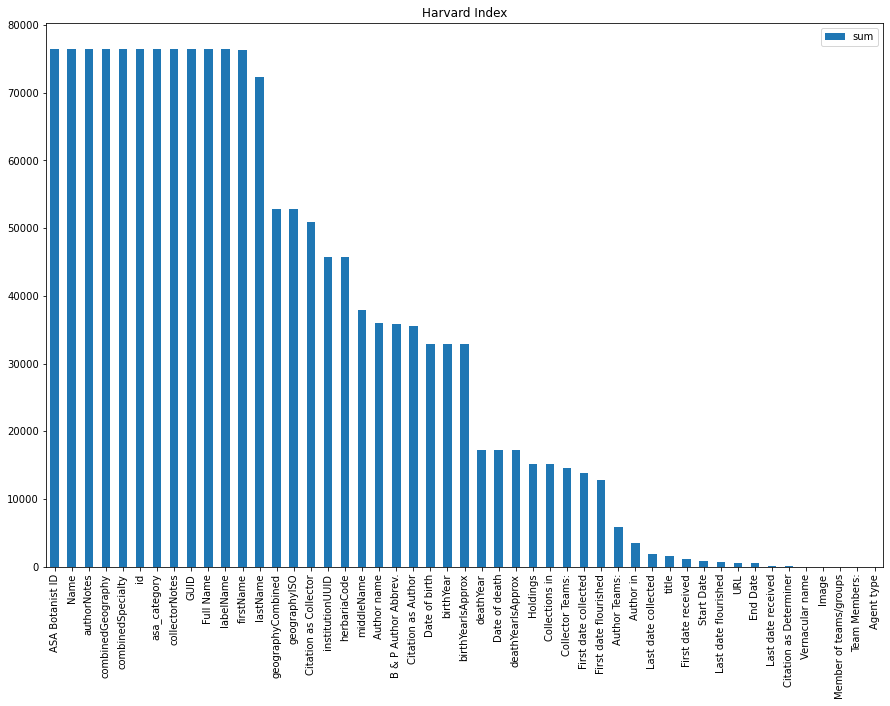

In [42]:
distribution = get_distribution(harvard_data, harvard_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10), title = 'Harvard Index')

                           sum
id                       71988
aliases                  71988
label                    71740
authorAbbrv              53828
IPNI                     53822
sexOrGender              50176
dateOfBirth              38647
harvardIndex             33413
dateOfDeath              27032
countryOfCitizenship     25364
VIAF                     23591
countryOfCitizenshipISO  22431
ISNI                     17629
bionomia                 12228
institutions             11113
birthName                 1099


<AxesSubplot:title={'center':'WikiData'}>

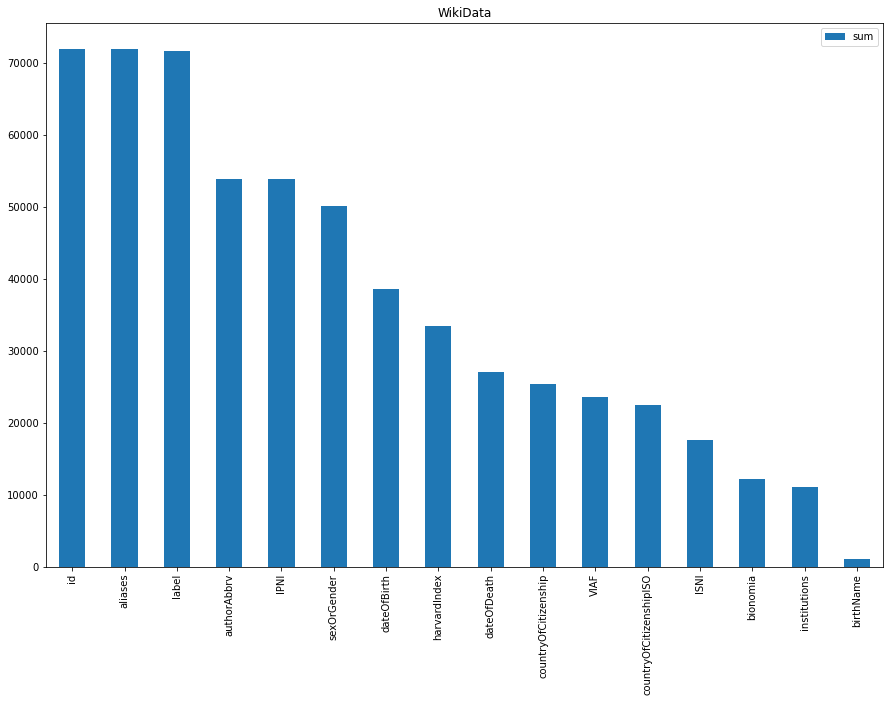

In [43]:
distribution = get_distribution(wiki_data, wiki_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10), title = 'WikiData')

In [ ]:
distribution = get_distribution(bionomia_data, bionomia_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10), title = 'Bionomia Index')

In [46]:
wiki_data.head()

,id,label,institutions,dateOfBirth,ISNI,countryOfCitizenshipISO,countryOfCitizenship,aliases,bionomia,dateOfDeath,sexOrGender,VIAF,IPNI,harvardIndex,authorAbbrv,birthName
0,Q100142069,Frida Eggens,NaN,NaN,NaN,['SE'],['Q34'],['Eggens'],NaN,NaN,female,NaN,20045232-1,NaN,Eggens,NaN
1,Q100146795,Elizabeth Harrison,NaN,1792.0,NaN,['GB'],"['Q161885', 'Q174193']","['Mrs Arnold Harrison', 'Mrs A. H.']",Q100146795,1834.0,female,NaN,NaN,NaN,NaN,NaN
2,Q100149196,Russell Cox,['9cfe8cbf-35ff-4d93-b932-cb05d91b7922'],NaN,NaN,NaN,NaN,[],0000-0001-5149-1709,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q100152296,Alda Pereira da Fonseca,NaN,1882.0,NaN,['BR'],['Q155'],[],NaN,NaN,female,NaN,NaN,NaN,NaN,NaN
4,Q100156193,Laurence Henry Millener,['c3d8b0e8-4b2b-4692-bfa7-73117d189508'],1914.0,NaN,['NZ'],['Q664'],"['L. H. Millener', 'Laurie Henry Millener', 'L...",Q100156193,2000.0,male,NaN,NaN,NaN,NaN,NaN


In [59]:
harvard_data.head()

,ASA Botanist ID,Author Teams:,Author name,B & P Author Abbrev.,Citation as Author,Collector Teams:,First date flourished,Full Name,GUID,Member of teams/groups,...,title,firstName,middleName,lastName,herbariaCode,institutionUUID,combinedSpecialty,combinedGeography,authorNotes,collectorNotes
0,190416 botanist,"Shin. Sato, D. G. Mann & MedlinShin. Sato, Koo...",Shin. Sato,Shin. Sato,Phycologia. [Journal of the International Phyc...,"Shin. Sato, D. G. Mann & L. K. MedlinShin. Sat...",2008,"Sato, Shinya",http://purl.oclc.org/net/edu.harvard.huh/guid/...,NaN,...,NaN,Shinya,NaN,Sato,NaN,NaN,{Algae},{Germany},[],[]
1,165120 botanist,NaN,E. J. Hoffman,E. J. Hoffman,"Authors of Plant Names. Royal Botanic Gardens,...",NaN,NaN,"Hoffman, Emily J.",http://purl.oclc.org/net/edu.harvard.huh/guid/...,NaN,...,NaN,Emily,J.,Hoffman,NaN,NaN,{Algae},{},[],[]
2,134899 botanist,"Artabe, Zamuner & D. W. Stevenson",D. W. Stevenson,D. W. Stev.,Index Herbariorum. Part 1: The Herbaria of the...,"D. W. Stevenson, S. E. Clemants & M. S. Steven...",NaN,"Stevenson, Dennis William",http://purl.oclc.org/net/edu.harvard.huh/guid/...,NaN,...,NaN,Dennis,William,Stevenson,{'NY'},['ab83e5ab-f4f7-4c9b-a1d5-eb779dfb9377'],"{Phanerogams, Spermatophytes, Pteridophytes}",{United States of America},[NY],[NY]
3,143150 botanist,NaN,D. Müller-Doblies,D. Müll.-Doblies,['Authors of Plant Names. Royal Botanic Garden...,NaN,NaN,"Müller-Doblies, Dietrich",http://purl.oclc.org/net/edu.harvard.huh/guid/...,NaN,...,NaN,Dietrich,NaN,Müller-Doblies,{'BTU'},['e131bcbc-86be-479e-8249-fe02290a3759'],{Spermatophytes},{Germany},[],[BTU]
4,183330 botanist,NaN,Boutroux,Boutroux,"Authors of Plant Names. Royal Botanic Gardens,...",NaN,1883,"Boutroux, A.",http://purl.oclc.org/net/edu.harvard.huh/guid/...,NaN,...,NaN,A.,NaN,Boutroux,NaN,NaN,"{Fungi, Lichens}",{},[],[]


In [62]:
a = wiki_data[['id','label','dateOfBirth','dateOfDeath','countryOfCitizenshipISO','institutions',
              'harvardIndex','bionomia','authorAbbrv','aliases']].copy()
a['firstName'] = a['label'].str.split('\s+').str[0]
a['lastName'] = a['label'].str.split('\s+').str[-1]
a['aliases'] = remove_spec_in_col(a,'aliases')
a['countryOfCitizenshipISO'] = remove_spec_in_col(a,'countryOfCitizenshipISO')
a['institutions'] = remove_spec_in_col(a,'institutions')
a['wikiID'] = a['id']
a = a.set_index('id')
a.head()

,label,dateOfBirth,dateOfDeath,countryOfCitizenshipISO,institutions,harvardIndex,bionomia,authorAbbrv,aliases,firstName,lastName,wikiID
id,,,,,,,,,,,,
Q100142069,Frida Eggens,NaN,NaN,SE,NaN,NaN,NaN,Eggens,Eggens,Frida,Eggens,Q100142069
Q100146795,Elizabeth Harrison,1792.0,1834.0,GB,NaN,NaN,Q100146795,NaN,"Mrs Arnold Harrison, Mrs A. H.",Elizabeth,Harrison,Q100146795
Q100149196,Russell Cox,NaN,NaN,NaN,9cfe8cbf-35ff-4d93-b932-cb05d91b7922,NaN,0000-0001-5149-1709,NaN,,Russell,Cox,Q100149196
Q100152296,Alda Pereira da Fonseca,1882.0,NaN,BR,NaN,NaN,NaN,NaN,,Alda,Fonseca,Q100152296
Q100156193,Laurence Henry Millener,1914.0,2000.0,NZ,c3d8b0e8-4b2b-4692-bfa7-73117d189508,NaN,Q100156193,NaN,"L. H. Millener, Laurie Henry Millener, Laurie ...",Laurence,Millener,Q100156193


In [ ]:
b = harvard_data[['id','labelName','birthYear','deathYear','geographyISO','institutionUUID',
                 'firstName','middleName','lastName','B & P Author Abbrev.','Name','herbariaCode']].copy()
b['Name'] = remove_spec_in_col(b,'Name')
b['geographyISO'] = remove_spec_in_col(b,'geographyISO')
b['herbariaCode'] = remove_spec_in_col(b,'herbariaCode')
b['institutionUUID'] = remove_spec_in_col(b,'institutionUUID')
b['harvardIndex'] = b['id']
b = b.set_index('id')
b.head()

In [58]:
c = bionomia_data[['orcid','wikidata','fullname','label','orgs','firstName','lastName',
              'countries','combined_fullname','dateOfBirth','dateOfDeath','acceptedNames']].copy()
c.head()

,orcid,wikidata,fullname,label,orgs,firstName,lastName,countries,combined_fullname,dateOfBirth,dateOfDeath,acceptedNames
0,None,Q108887181,A. R. Christiaensen,A. R. Christiaensen,None,A. R.,Christiaensen,None,A. R. Christiaensen,1966,NaN,[A. Christiaensen]
1,0000-0001-7348-143X,None,Fabian A. Michelangeli,None,Q636275,Fabian A.,Michelangeli,US,Fabian A. Michelangeli,NaN,NaN,"[F. A. Michelangeli, Fabian A. Michelangeli, F..."
2,0000-0001-5980-1417,None,Jairo A. Moreno-González,None,None,Jairo A.,Moreno-González,None,Jairo A. Moreno-González,NaN,NaN,[]
3,0000-0001-7835-0295,None,Dean A. Hendrickson,Dean A. Hendrickson,Q49213,Dean A.,Hendrickson,US,Dean A. Hendrickson,NaN,NaN,"[D.A. Hendrickson, Dean Hendrickson, D. Hendri..."
4,0000-0001-6004-7730,None,Jonathan A. Coddington,None,None,Jonathan A.,Coddington,None,Jonathan A. Coddington,NaN,NaN,[]


In [ ]:
a.to_csv('a.csv', sep=',', encoding='utf-8')
b.to_csv('b.csv', sep=',', encoding='utf-8')
c.to_csv('c.csv', sep=',', encoding='utf-8')